final evaluation on Test-A set using the trained CNN and the KNN classifier on CNN embeddings


In [7]:
import tensorflow as tf
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np

In [8]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/white-blood-cells-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'white-blood-cells-dataset' dataset.
Path to dataset files: /kaggle/input/white-blood-cells-dataset


In [9]:
%cd /content/drive/MyDrive/projects/wbc-cnn-knn-classifier

/content/drive/MyDrive/projects/wbc-cnn-knn-classifier


In [10]:
from src.cleaning import create_dataset , relpaths_to_fullpaths

2.19.0


In [11]:
Test_A = pd.read_csv("data/splits/Test_A.csv")
Test_A.head()

,path,label
0,Test-A/Eosinophil/95-8-27-1_93_3.jpg,1
1,Test-A/Neutrophil/95-9-3-5_139_1.jpg,4
2,Test-A/Lymphocyte/95-9-3-4_145_1.jpg,2
3,Test-A/Lymphocyte/95-9-1-2_237_1.jpg,2
4,Test-A/Neutrophil/95-8-17-1_227_1.jpg,4


In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
a_paths, a_labels = Test_A["path"].values, Test_A["label"].values
a_paths = relpaths_to_fullpaths(path,a_paths)
print(type(a_labels))

<class 'numpy.ndarray'>


In [14]:
a_paths[1]

'/kaggle/input/white-blood-cells-dataset/Test-A/Neutrophil/95-9-3-5_139_1.jpg'

In [15]:
a_dataset = create_dataset(a_paths,a_labels)


In [16]:
for images, labels in a_dataset.take(1):
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [17]:
encoder = tf.keras.models.load_model("/content/drive/MyDrive/projects/wbc-cnn-knn-classifier/models/encoder/feature_encoder.keras")

In [18]:
def label_extraction(ds):
  ys = []
  for _,y in ds :
    ys.append(y.numpy()) #y is a whole batch of 32 label
  return np.concatenate(ys,axis=0) #it was a list of list of 32 labes each batch was a list inside ys

In [19]:
#extracting the labels from the dataset object
a_y = label_extraction(a_dataset)


In [20]:
print(a_y.shape)


(4339,)


In [21]:
a_X = encoder.predict(a_dataset,verbose = 1)
print(a_X.shape)


136/136 ━━━━━━━━━━━━━━━━━━━━ 38s 173ms/step
(4339, 1280)


In [22]:
import os
os.makedirs("data/vectors", exist_ok=True)

OUT_DIR = "/content/drive/MyDrive/projects/wbc-cnn-knn-classifier/data/vectors"
np.save(os.path.join(OUT_DIR, "Test_A_vectors.npy"), a_X)
np.save(os.path.join(OUT_DIR, "Test_A_labels.npy"), a_y)

In [23]:
import joblib

In [24]:
cd /content/drive/MyDrive/projects/wbc-cnn-knn-classifier

/content/drive/MyDrive/projects/wbc-cnn-knn-classifier


In [25]:
cnn_model = tf.keras.models.load_model(
    "models/finetuned/final_model_finetuned.keras"
)

cnn_model.summary()




Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,770,708 (25.83 MB)

 Trainable params: 1,357,365 (5.18 MB)

 Non-trainable params: 2,698,611 (10.29 MB)

 Optimizer params: 2,714,732 (10.36 MB)

In [26]:
import joblib

knn_model = joblib.load("models/knn/knn_best.joblib")
#joblib store scaler and pca(not used here)


In [27]:
cnn_loss, cnn_acc = cnn_model.evaluate(a_dataset)
print("CNN Test-A accuracy:", cnn_acc)


136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 92ms/step - accuracy: 0.9438 - loss: 0.1966
CNN Test-A accuracy: 0.9426134824752808


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_prob = cnn_model.predict(a_dataset)
y_pred = np.argmax(y_prob, axis=1)
y_true = np.concatenate([y for _, y in a_dataset], axis=0)

print(classification_report(y_true, y_pred))


136/136 ━━━━━━━━━━━━━━━━━━━━ 22s 109ms/step
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        89
           1       0.66      0.93      0.77       322
           2       0.96      0.98      0.97      1034
           3       0.88      0.87      0.88       234
           4       0.99      0.93      0.96      2660

    accuracy                           0.94      4339
   macro avg       0.90      0.94      0.91      4339
weighted avg       0.95      0.94      0.95      4339



In [30]:
import numpy as np



y_pred_knn = knn_model.predict(a_X)

from sklearn.metrics import accuracy_score, classification_report
print("KNN Test-A accuracy:", accuracy_score(a_y, y_pred_knn))
print(classification_report(a_y, y_pred_knn))


KNN Test-A accuracy: 0.9287854344318968
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        89
           1       0.70      0.91      0.79       322
           2       0.91      0.98      0.94      1034
           3       0.90      0.71      0.79       234
           4       0.98      0.93      0.95      2660

    accuracy                           0.93      4339
   macro avg       0.89      0.90      0.89      4339
weighted avg       0.94      0.93      0.93      4339



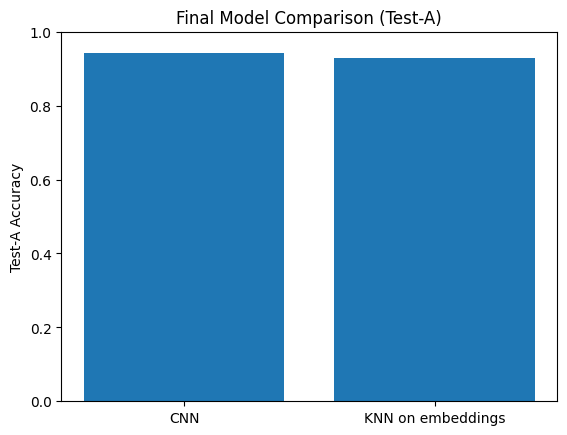

In [32]:
import matplotlib.pyplot as plt

models = ["CNN", "KNN on embeddings"]
accs = [cnn_acc, accuracy_score(a_y, y_pred_knn)]

plt.bar(models, accs)
plt.ylabel("Test-A Accuracy")
plt.title("Final Model Comparison (Test-A)")
plt.ylim(0, 1)
plt.show()
